In [1]:
from cellpose import models, io
from cellpose.io import *
from collections import defaultdict
import geopandas
import glob
import imagej
from jpype import JArray, JInt
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import os
import re
import pandas
from pandas import DataFrame
from pathlib import Path
import scyjava
import seaborn
import shutil
import tkinter as tk
from tkinter import filedialog
from PIL import Image

In [2]:
scyjava.config.add_option('-Xmx30g')
start_dir = os.getcwd()
#ij = imagej.init('sc.fiji:fiji', mode='interactive')
ij = imagej.init('/home/saka/sw/local/fiji/2023', mode='interactive')
## Something about this init() function changes the current working directory.
ij.getApp().getInfo(True)
#ij.ui().showUI()
os.chdir(start_dir)
ij.getVersion() #This is to make sure ImageJ/Fiji opened properly. In case of error, it could display '2.9.0/inactive' instead of the full version number

'2.9.0/1.54e'

In [3]:
showPolygonRoi = scyjava.jimport('ij.gui.PolygonRoi')
Overlay = scyjava.jimport('ij.gui.Overlay')
Regions = scyjava.jimport('net.imglib2.roi.Regions')
LabelRegions = scyjava.jimport('net.imglib2.roi.labeling.LabelRegions')
ZProjector = scyjava.jimport('ij.plugin.ZProjector')()
rm = ij.RoiManager.getRoiManager()
ov = Overlay()

In [4]:
ij.ui().showUI()

In [7]:
# Dialog window to get the path of the working directory
root = tk.Tk()
root.withdraw()
# Set the path to the directory containing the images
directory_path = filedialog.askdirectory()
folder_list = os.listdir(directory_path)

In [ ]:
for folder in folder_list:
    # Get the path to the folder
    folder_path = os.path.join(directory_path, folder)
     # Find all the ".czi" files in the folder
    file_pattern = os.path.join(folder_path, "Image_CH3.tif")
    file_list = glob.glob(file_pattern)
    for file_path in file_list:
        image = ij.io().open(file_path)
        imp = ij.py.to_imageplus(image)
        # Change bit depth to 8-bit
        ij.IJ.run(imp, "8-bit", "")
        # Flatten the image
        flatten = imp.flatten()
        ij.IJ.run(flatten, "8-bit", "")
        results = ij.py.from_java(flatten)
        flatten_image = ij.py.to_dataset(results) 
        result_path = os.path.splitext(file_path)[0] + "_flatten.tif"
        ij.io().save(flatten_image, result_path)
        print(f"Saving image {result_path}.")

In [ ]:
for folder in folder_list:
    # Get the path to the folder
    folder_path = os.path.join(directory_path, folder)
     # Find all the ".czi" files in the folder
    file_pattern = os.path.join(folder_path, "Image_CH2.tif")
    file_list = glob.glob(file_pattern)
    for file_path in file_list:
        image = ij.io().open(file_path)
        imp = ij.py.to_imageplus(image)
        # Change bit depth to 8-bit
        ij.IJ.run(imp, "8-bit", "")
        # Flatten the image
        flatten = imp.flatten()
        ij.IJ.run(flatten, "8-bit", "")
        results = ij.py.from_java(flatten)
        flatten_image = ij.py.to_dataset(results) 
        result_path = os.path.splitext(file_path)[0] + "_flatten.tif"
        ij.io().save(flatten_image, result_path)
        print(f"Saving image {result_path}.")

In [ ]:
for folder in folder_list:
    # Get the path to the folder
    folder_path = os.path.join(directory_path, folder)
     # Find all the ".czi" files in the folder
    file_pattern = os.path.join(folder_path, "Image_CH4.tif")
    file_list = glob.glob(file_pattern)
    for file_path in file_list:
        image = ij.io().open(file_path)
        imp = ij.py.to_imageplus(image)
        # Change bit depth to 8-bit
        ij.IJ.run(imp, "8-bit", "")
        # Flatten the image
        flatten = imp.flatten()
        ij.IJ.run(flatten, "8-bit", "")
        results = ij.py.from_java(flatten)
        flatten_image = ij.py.to_dataset(results) 
        result_path = os.path.splitext(file_path)[0] + "_flatten.tif"
        ij.io().save(flatten_image, result_path)
        print(f"Saving image {result_path}.")

workflow to only segmentate a particular image !!!

In [ ]:
for folder in folder_list:
    # Get the path to the folder
    folder_path = os.path.join(directory_path, folder)
    file_pattern = os.path.join(folder_path, "Image_CH3_flatten.tif")
    file_list = glob.glob(file_pattern)
    model = models.CellposeModel(gpu=True, model_type='sty_fluo_low_8')
    for file_path in file_list:
        imgs = io.imread(file_path)
        channels = [[0,0]]
        diameter = 21.622
        masks, flows, styles = model.eval(imgs, diameter=diameter, channels=channels)
        io.save_to_png(imgs, masks, flows, file_path)

In [ ]:
rm = ij.RoiManager.getRoiManager()
for folder in folder_list:
    # Get the path to the folder
    folder_path = os.path.join(directory_path, folder)
    file_pattern = os.path.join(folder_path, "Image_CH3_flatten.tif")
    image_red = ij.io().open(file_pattern)
    imp = ij.py.to_imageplus(image_red)
    input_txt = Path(f"{folder_path}/Image_CH3_flatten_cp_outlines.txt")
    txt_fh = open(input_txt, 'r')
    for line in txt_fh:
        xy = line.rstrip().split(",")
        xy_coords = [int(element) for element in xy if element not in '']
        x_coords = [int(element) for element in xy[::2] if element not in '']
        y_coords = [int(element) for element in xy[1::2] if element not in '']
        xcoords_jint = JArray(JInt)(x_coords)
        ycoords_jint = JArray(JInt)(y_coords)
        polygon_roi_instance = scyjava.jimport('ij.gui.PolygonRoi')
        roi_instance = scyjava.jimport('ij.gui.Roi')
        imported_polygon = polygon_roi_instance(xcoords_jint, ycoords_jint, len(x_coords), int(roi_instance.POLYGON))
        imp.setRoi(imported_polygon)
        rm.addRoi(imported_polygon)
    ij.py.run_macro("roiManager('Select All');")
    rm.runCommand("Save", f"{folder_path}/" + f"RoiSet.zip")
    ij.py.run_macro("roiManager('Select All');")
    rm.runCommand("Delete")

In [ ]:
for folder in folder_list:
    # Get the path to the folder
    folder_path = os.path.join(directory_path, folder)
    Yellow = Path(f"{folder_path}/Image_CH2_flatten.tif").as_posix()
    Red = Path(f"{folder_path}/Image_CH3_flatten.tif").as_posix()
    cyan = Path(f"{folder_path}/Image_CH4_flatten.tif").as_posix()
    
    image_yellow = ij.io().open(Yellow)
    image_red = ij.io().open(Red)
    image_cyan = ij.io().open(cyan)
    ij.ui().show(image_yellow)
    ij.ui().show(image_red)
    ij.ui().show(image_cyan)
    
    merge_channels = """
    selectWindow("Image_CH2_flatten.tif");
    run("8-bit");
    run("Yellow");
    selectWindow("Image_CH4_flatten.tif");
    run("8-bit");
    run("Cyan");
    selectWindow("Image_CH3_flatten.tif");
    run("8-bit");
    run("Red");
    run("Merge Channels...", "-stack c1=Image_CH3_flatten.tif c5=Image_CH4_flatten.tif c7=Image_CH2_flatten.tif create");
    selectWindow("Composite");

    """
    
    ij.py.run_macro(merge_channels)
    flatten_image = ij.py.from_java("Composite")
    result_path = os.path.join(folder_path, "Composite.tif")
    format = f'Tiff'
    set_string = f'saveAs("{format}", "{result_path}")'
    #measure_string = f'area mean min centroid median skewness kurtosis integrated stack redirect=None decimal=3'
    ij.py.run_macro(set_string)
    ij.py.run_macro("close();")
    
    


In [ ]:
rm = ij.RoiManager.getRoiManager()
for folder in folder_list:
    # Get the path to the folder
    folder_path = os.path.join(directory_path, folder)    
    composite = Path(f"{folder_path}/Composite.tif").as_posix()
    image_composite = f'open("{composite}")'
    imp = ij.py.run_macro(image_composite)
    ij.ui().show(imp)
    set_string = f'Set Measurements...'
    measure_string = f'area mean stack redirect=None decimal=2'
    ij.IJ.run(set_string, measure_string)
    input_ROI = Path(f"{folder_path}/RoiSet.zip")
    rm.open(f"{input_ROI}")
    measure = """
    run("Set Measurements...", "area mean stack redirect=None decimal=2");
    Stack.setChannel(1);
    nbArea=roiManager("count")
    for (i=0; i<nbArea; i++) {
		roiManager("Select", i);
        run("Measure");	
	}
    Stack.setChannel(2);
    nbArea=roiManager("count")
    for (i=0; i<nbArea; i++) {
		roiManager("Select", i);
        run("Measure");	
    }
    Stack.setChannel(3);
    nbArea=roiManager("count")
    for (i=0; i<nbArea; i++) {
		roiManager("Select", i);
		run("Measure");	
    }
    roiManager('Select All');
    roiManager("Delete");
    close("*");  
    """
    ij.py.run_macro(measure)
    measurements = ij.ResultsTable.getResultsTable()
    measurements_table = ij.convert().convert(measurements, scyjava.jimport('org.scijava.table.Table'))
    table = ij.py.from_java(measurements_table)
    results = os.path.basename(folder_path)
    results = os.path.splitext(results)[0]
    output_path = Path(f"{folder_path}/{results}.csv")
    table.to_csv(output_path)
    clear = """selectWindow("Results");
run("Clear Results");
    """
    ij.py.run_macro(clear)

In [ ]:
root = tk.Tk()
root.withdraw()
# Set the path to the directory containing the images
directory_path = filedialog.askdirectory()

In [ ]:
Yellow = Path(f"{directory_path}/Image_CH2_flatten.tif").as_posix()
Red = Path(f"{directory_path}/Image_CH3_flatten.tif").as_posix()
cyan = Path(f"{directory_path}/Image_CH4_flatten.tif").as_posix()
    
image_yellow = ij.io().open(Yellow)
image_red = ij.io().open(Red)
image_cyan = ij.io().open(cyan)
ij.ui().show(image_yellow)
ij.ui().show(image_red)
ij.ui().show(image_cyan)

merge_channels = """
    selectWindow("Image_CH2_flatten.tif");
run("8-bit");
run("Yellow");
selectWindow("Image_CH4_flatten.tif");
run("8-bit");
run("Cyan");
selectWindow("Image_CH3_flatten.tif");
run("8-bit");
run("Red");
run("Merge Channels...", "-stack c1=Image_CH3_flatten.tif c5=Image_CH4_flatten.tif c7=Image_CH2_flatten.tif create");
selectWindow("Composite");

"""
    
ij.py.run_macro(merge_channels)

flatten_image = ij.py.from_java("Composite")
result_path = os.path.join(directory_path, "Composite.tif")
format = f'Tiff'
set_string = f'saveAs("{format}", "{result_path}")'
ij.py.run_macro(set_string)

In [8]:
rm = ij.RoiManager.getRoiManager()
for folder in folder_list:
    # Get the path to the folder
    folder_path = os.path.join(directory_path, folder)    
    red = Path(f"{folder_path}/Image_CH3_flatten.tif").as_posix()
    image = f'open("{red}")'
    imp = ij.py.run_macro(image)
    ij.ui().show(imp)
    set_string = f'Set Measurements...'
    measure_string = f'area mean stack redirect=None decimal=2'
    ij.IJ.run(set_string, measure_string)
    input_ROI = Path(f"{folder_path}/RoiSet.zip")
    rm.open(f"{input_ROI}")
    measure = """
    run("Set Measurements...", "area mean stack redirect=None decimal=2");
    run("Set Scale...", "distance=1 known=0.12581 unit=µm");
    nbArea=roiManager("count")
    for (i=0; i<nbArea; i++) {
		roiManager("Select", i);
        run("Measure");	
	}
    roiManager('Select All');
    roiManager("Delete");
    close("*");  
    """
    ij.py.run_macro(measure)
    measurements = ij.ResultsTable.getResultsTable()
    measurements_table = ij.convert().convert(measurements, scyjava.jimport('org.scijava.table.Table'))
    table = ij.py.from_java(measurements_table)
    results = os.path.basename(folder_path)
    results = os.path.splitext(results)[0]
    output_path = Path(f"{folder_path}/{results}_red.csv")
    table.to_csv(output_path)
    clear = """selectWindow("Results");
    run("Clear Results");
    """
    ij.py.run_macro(clear)

In [ ]:

folder_prefix = "1_"
results = []
for folder in folder_list:
    folder_path = os.path.join(directory_path, folder)
    f_name = os.path.basename(folder_path)
    file_pattern = Path(f"{folder_path}/{f_name}_red.csv").as_posix()
    file_list = glob.glob(file_pattern)
    for file_path in file_list:
        df = pandas.read_csv(file_path)
        mean = df['Mean']
        results.append(mean)
        
    final_result = pandas.concat(results,ignore_index=True)
    output_path = Path(f"{folder_path}/{results}_red.csv")
    final_result.to_csv(
    print(final_result)

In [18]:
# Dialog window to get the path of the working directory
root = tk.Tk()
root.withdraw()
# Set the path to the directory containing the images
directory_path = filedialog.askdirectory()
folder_list = os.listdir(directory_path)

In [ ]:
print(len(folder_list))

In [ ]:
folder_prefix = "1_"
for i in folder_list:
    root = f"{folder_prefix}{i}"
    folder_pattern = os.path.join(directory_path, root)
    os.chdir(folder_pattern)
    file_pattern = Path(f"{folder_path}/{folder_pattern}{root}_red.csv").as_posix()
    file_list = glob.glob(file_pattern)

In [19]:
root = tk.Tk()
root.withdraw()
dataset = filedialog.askopenfilename()

In [20]:
df = pandas.read_csv(dataset)
#df = df.rename(columns={'LB_pH7': 'pH7'})
#df = df.rename(columns={'LB_pH4.5': 'pH4.5'})
df.head()

,pH7,pH4.5
0,3.118147,3.498022
1,4.859244,3.957039
2,2.485021,3.656304
3,1.377050,2.611646
4,2.405880,3.719617


In [ ]:
#df2 = df['bacterial_volume']

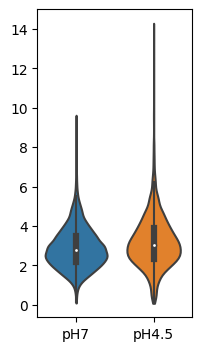

In [21]:
plt.figure(figsize=(2, 4))
prout = seaborn.violinplot(data=df, cut=0)
#plt.savefig(result)

In [22]:
result = Path(f"{directory_path}/plot_diagram_area.svg")
violin = prout.get_figure()
violin.savefig(result)